# Genetic algorithm for Water Distribution Systems - Optimization project (2/2)

**Objectives:**
- Implement a genetic algorithm to find an appropriate solution for the optimization of a water distribution system.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the optimization problem
  - Solving the optimization problem
  - Analyzing the optimization problem
- Answered all the questions

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- WNTR
- PyMOO

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Library for analysis of Water distribution networks
import wntr

#Genetic algorithm dependencies
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling

## 🔙 Background

### 💧 Water distribution systems

As cities grow, so does the challenge of getting water to everyone efficiently. Imagine a giant puzzle where water has to travel from its source, like a reservoir, to homes, stores, and factories. This puzzle gets even trickier in cities because there are many more places that need water, and we need to make sure that if one part of the system breaks, others are still connected. That is why we have looped systems as the one in Figure 1.

However, figuring out the best way to design these water networks is a real challenge. It's like solving a complex puzzle. Using the methods we learned before, like linear programming, isn't practical anymore. We need a different approach.

In this assignment, we're going to use a genetic algorithm to address this problem. In order to reduce some complexity of the problem, each pipe line will have only one diameter. This makes facilitates the problem; however, there is still an enourmous amount of possibilities to consider.

To help us calculate the hydraulics in the system, we'll use a numerical model for calculating the pressure for all the nodes. This model will help us understand how much pressure there is at different points in the water network. By figuring this out, we can create a system that reliably delivers water to every corner of the city.

<div>
<center><img src="./Images/Modena.png" width="600"/></center>
</div>

Figure 1. Numerical results for the water distribution system in the city of Modena, Italy.

### 🖥Numerical model

The Water Network Tool for Resilience (WNTR) is a powerful and flexible Python library designed for modeling, simulating, and analyzing water distribution systems. WNTR is based upon EPANET, which is a widely used software tool for simulating and analyzing water distribution systems. It plays a crucial role in the management and design of water distribution networks by enabling engineers and researchers to model, simulate, and optimize the complex interactions within these systems.

In this notebook, we are going to use this library to compute the pressures at the nodes given diverse configurations of diameters.

<div style="display: flex;">
<center>
    <img src="./Images/Epanet_Logo.png" alt="Image 1" style="width: 18%; height: auto;">
    <img src="./Images/wntr_logo.webp" alt="Image 2" style="width: 50%; height: auto;">
</center>
</div>
Figure 2. EPANET and WNTR logos.



### 🧬Genetic algorithm

Genetic Algorithms (GAs) are powerful optimization techniques inspired by the process of natural evolution. They have gained prominence in solving complex problems across various fields, ranging from engineering and economics to artificial intelligence. Here, we give a brief overview of Genetic Algorithms, highlighting their fundamental principles, components, and applications in solving optimization problems.

At the heart of a Genetic Algorithm are populations of potential solutions, represented as individuals or chromosomes. These individuals evolve over generations to improve their fitness with respect to the given optimization objective.

Basic Components of a Genetic Algorithm:
- **Population**: A collection of individuals representing potential solutions to the problem.
- **Fitness** Function: Quantifies the quality of each individual's solution with respect to the optimization objective.
- **Selection**: Individuals are chosen based on their fitness to serve as parents for the next generation.
- **Crossover**: Genetic material from parents is combined to create offspring with potentially improved traits.
- **Mutation**: Random changes are introduced in offspring to maintain diversity and explore new solution spaces.
- **Replacement**: New offspring replace some of the least fit individuals in the population.
- **Termination Criteria**: Conditions under which the algorithm stops, e.g., a maximum number of generations or satisfactory fitness level.

Working Principle:

- **Initialization**: A population of random individuals is generated to start the algorithm.
- **Evaluation**: The fitness function assesses the quality of each individual's solution.
- **Selection**: Individuals with higher fitness have a higher chance of being selected as parents.
- **Crossover**: Genetic material from selected parents is combined to create offspring.
- **Mutation**: Random changes are introduced to some offspring to maintain diversity.
- **Replacement**: New offspring replace some individuals in the population.
- **Termination**: The algorithm stops when a termination criterion is met.

#### PyMOO Library

PyMOO is a Python library that provides a comprehensive and easy-to-use framework for multi-objective optimization (MOO). For this case, we are going to deal with only one objective; nevertheless, this is an useful tool if you have more objectives. In addition, PyMOO easily allows us to define our optimization problem by specifying the objectives, constraints, and decision variables

## ⛔ Problem definition 

The problem is to find the pipe diameters that minimize the cost of the pipe lines while satisfying the customer demand for water usage and supply pressure. 

<!-- For this application, we will only consider systems feed by reservoirs that work via gravity. -->

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider one main restriction.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{i=1}^{N} H_{i} \leq H^{*} 
$$

<!-- \; \text{for every node i in the system.} -->

## 💻 Genetic algorithm - Example

We exemplify the implementation of these algorithms with the system "Two loop network (TLN)". This system consists of one reservoir, six demand nodes and eight pipes organised in two loops. The reservoir has a constant head fixed at 210 m. As a hypothetical network all pipes have the same length (1000 m). The pressure is set to be at least 30.0 m at all demand nodes. The following table shows commercially available diameters and the corresponding unit costs (1 in.=0.0254 m). 

| Diameter [in] | 1    | 2    | 3    | 4    | 6    | 8    | 10   | 12   | 14   | 16   | 18   | 20   | 22   | 24   |
|-------------------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| Cost per meter [€/m] | 2    | 5    | 8    | 11   | 16   | 23   | 32   | 50   | 60   | 90   | 130  | 170  | 300  | 500  |


<!-- and the Hazen-Williams coefficient of 130. -->

<div>
<center><img src="./Images/TLN_image.png" width="300"/></center>
</div>


First, let's define some preliminary variables and functions that are going to be used later.

In [2]:
IN_TO_M = 0.0254

cost_function_diameter_inches = {
    1: 2,
    2: 5,
    3: 8,
    4: 11,
    6: 16,
    8: 23,
    10: 32,
    12: 50,
    14: 60,
    16: 90,
    18: 130,
    20: 170,
    22: 300,
    24: 500
}

pipe_index = {
    0:1,
    1:2,
    2:3,
    3:4,
    4:6,
    5:8,
    6:10,
    7:12,
    8:14,
    9:16,
    10:18,
    11:20,
    12:22,
    13:24
    }

H_star = 20

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

Here, we use the WNTR library to load the data from TLN. This creates the variable **wn** which stores all the information about the nodes, pipes, reservoirs and other components of the water network.

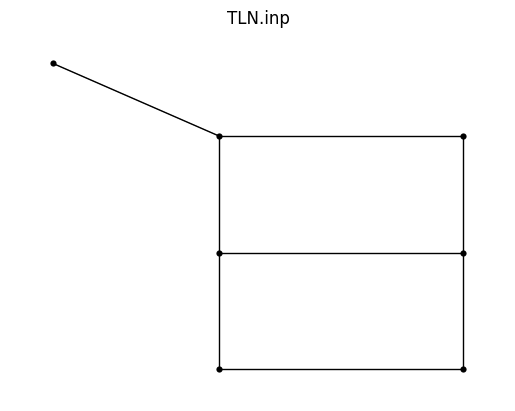

<Axes: title={'center': 'TLN.inp'}>

In [3]:
# Create a water network model
inp_file = 'TLN.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

Here, we use the PyMOO library to define and solve the optimization problem.

In [ ]:
#Problem definition:
population_size = 100
class TwoLoopOptimization(Problem):
    def __init__(self):
        #Here, we indicate that our problem has:
        super().__init__(n_var=8,        #8 decision variables (one diameter per pipe)
                         n_obj=1,        #1 objective
                         n_ieq_constr=6, #6 inequality constraints
                         xl=0.0,         #0 as beginning index to search
                         xu=13.0,        #13 as final index to search
                         vtype=int)      #integer as type of variable 
        

    def _evaluate(self, x, out, *args, **kwargs):
        #x contains a population of all individuals (proposed solutions)
        #Here we map the indexes of each individual to the corresponding pipes
        new_x = transform_index_to_diameter(x, pipe_index)
        pressure_heads   = np.zeros((population_size, 6))
        individual_costs = np.zeros((population_size,1))
        
        #In here, for each individual of the population, we run the numerical simulation
        for i, individual in enumerate(new_x):
            cost = 0
            #First, we modify the pipes
            for j, pipe_name in enumerate(wn.pipe_name_list):
                pipe = wn.get_link(pipe_name)
                # Modify the water network 
                pipe.diameter = individual[j] * IN_TO_M
                # Calculate the cost of the network
                cost += cost_function_diameter_inches[individual[j]] * pipe.length
            
            individual_costs[i] = cost

            #Simulate the water network with the modified individual
            sim = wntr.sim.EpanetSimulator(wn)
            results = sim.run_sim()

            pressure_heads[i,:]= results.node['head'].values[0][:-1]
        
        out["F"] = individual_costs          #In F, we store the objective function
        out["G"] = -(pressure_heads - H_star)#In G, we store the restrictions, notice the minus sign as the restrictions are all in the form G <= 0

In [17]:
problem = TwoLoopOptimization()

method = GA(pop_size=population_size,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            )

res = minimize(problem,
               method,
               termination=('n_gen', 100),
               seed=1,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  0.000000E+00 |  2.362708E+06 |  8.072500E+05 |  3.930000E+05
     2 |      200 |  0.000000E+00 |  6.800838E+01 |  8.195949E+05 |  3.190000E+05
     3 |      300 |  0.000000E+00 |  0.000000E+00 |  6.033500E+05 |  3.190000E+05
     4 |      400 |  0.000000E+00 |  0.000000E+00 |  4.825700E+05 |  2.800000E+05
     5 |      500 |  0.000000E+00 |  0.000000E+00 |  4.124900E+05 |  2.430000E+05
     6 |      600 |  0.000000E+00 |  0.000000E+00 |  3.521800E+05 |  2.280000E+05
     7 |      700 |  0.000000E+00 |  0.000000E+00 |  3.120000E+05 |  2.140000E+05
     8 |      800 |  0.000000E+00 |  0.000000E+00 |  2.811600E+05 |  2.130000E+05
     9 |      900 |  0.000000E+00 |  0.000000E+00 |  2.632800E+05 |  1.980000E+05
    10 |     1000 |  0.000000E+00 |  0.000000E+00 |  2.466500E+05 |  1.880000E+05
    11 |     1100 |  0.000000E+00 |  0.000000E+00 |  2.324100E+05 |  1.880000E+05
    12 |     120

Evaluate best solution

In [20]:
optimal_diameters = transform_index_to_diameter([res.X], pipe_index)[0]*IN_TO_M
print(optimal_diameters)

[0.305 0.102 0.254 0.203 0.254 0.203 0.025 0.025]


In [21]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]

In [22]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

In [23]:
results.node['head']

name,2,3,4,5,6,7,1
0,161.330154,45.874092,79.038292,53.587803,49.546474,35.241459,210.0


## 🏋🏽‍♀️ Exercise: Genetic algorithm

| Diameter [mm] |   100 |   125 |   150 |   200 |   250 |   300 |   350 |   400 |   450 |   500 |   600 |   700 |   800 |
|--------------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| Cost per meter [€/m] |  27.7 |  38.0 |  40.5 |  55.4 |  75.0 |  92.4 | 123.1 | 141.9 | 169.3 | 191.5 | 246.0 | 319.6 | 391.1 |


WNTR

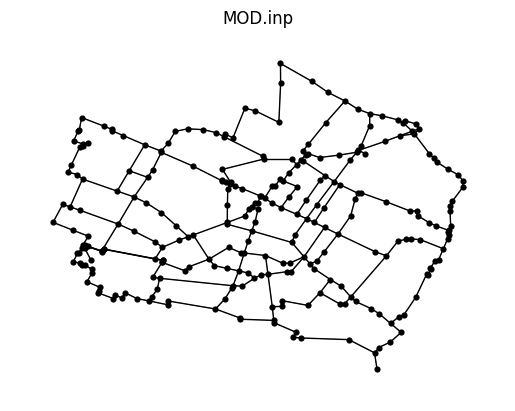

<Axes: title={'center': 'MOD.inp'}>

In [24]:
# Create a water network model
inp_file = 'MOD.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)


In [25]:
MM_TO_M = 0.001
cost_function_diameter_mm = {
    100: 27.7,
    125: 38.0,
    150: 40.5,
    200: 55.4,
    250: 75.0,
    300: 92.4,
    350: 123.1,
    400: 141.9,
    450: 169.3,
    500: 191.5,
    600: 246.0,
    700: 319.6,
    800: 391.1
}

pipe_index = {
    0:100,
    1:125,
    2:150,
    3:200,
    4:250,
    5:300,
    6:350,
    7:400,
    8:450,
    9:500,
    10:600,
    11:700,
    12:800,
    }

H_star = 20

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

In [26]:
class ModenaOptimization(Problem):
    
    def __init__(self):
        super().__init__(n_var=317, n_obj=1, n_ieq_constr=268, xl=0.0, xu=12.0, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):

        new_x = transform_index_to_diameter(x, pipe_index)
        pressure_heads = np.zeros((20, 268))
        individual_costs = np.zeros((20,1))
        # Modify the water network 
        for i, individual in enumerate(new_x):
            cost = 0
            for j, pipe_name in enumerate(wn.pipe_name_list):
                pipe = wn.get_link(pipe_name)
                pipe.diameter = individual[j] * MM_TO_M
                cost += cost_function_diameter_mm[individual[j]] * pipe.length
            
            individual_costs[i] = cost
            #Simulate the individual
            sim = wntr.sim.EpanetSimulator(wn)
            results = sim.run_sim()

            #
            pressure_heads[i,:]= results.node['head'].values[0][:-4] #Excluding the 4 reservoirs
        
        out["F"] = individual_costs#new_x @ np.array([[1, 2, 3, 4, 5, 6, 7, 8]]).transpose()
        out["G"] = -(pressure_heads - H_star)

problem = ModenaOptimization()

method = GA(pop_size=20,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            )

res = minimize(problem,
               method,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  0.000000E+00 |  0.000000E+00 |  1.009557E+07 |  9.148062E+06
     2 |       40 |  0.000000E+00 |  0.000000E+00 |  9.169780E+06 |  7.622350E+06
     3 |       60 |  0.000000E+00 |  0.000000E+00 |  8.177076E+06 |  6.439084E+06
     4 |       80 |  0.000000E+00 |  0.000000E+00 |  7.119703E+06 |  6.295733E+06
     5 |      100 |  0.000000E+00 |  0.000000E+00 |  6.455269E+06 |  5.460360E+06
     6 |      120 |  0.000000E+00 |  0.000000E+00 |  5.915198E+06 |  4.842441E+06
     7 |      140 |  0.000000E+00 |  0.000000E+00 |  5.273315E+06 |  4.425332E+06
     8 |      160 |  0.000000E+00 |  0.000000E+00 |  4.834673E+06 |  4.425332E+06
     9 |      180 |  0.000000E+00 |  0.000000E+00 |  4.517469E+06 |  4.114552E+06
    10 |      200 |  0.000000E+00 |  0.000000E+00 |  4.375625E+06 |  4.114552E+06
Best solution found: [ 4  3  1  0  7  3  0  1  2  0  2  0  4  0  5  1  1  6  8  1  3  1  8  0  2  

In [34]:
optimal_diameters = transform_index_to_diameter([res.X], pipe_index)[0]*MM_TO_M
print(optimal_diameters)

[0.25  0.2   0.125 0.1   0.4   0.2   0.1   0.125 0.15  0.1   0.15  0.1   0.25  0.1   0.3   0.125 0.125 0.35  0.45  0.125 0.2   0.125 0.45  0.1   0.15  0.15  0.125 0.1   0.2   0.2   0.2   0.25  0.15  0.2   0.15  0.125 0.3   0.1   0.25  0.125 0.1   0.1   0.125 0.2   0.125 0.3   0.3   0.15  0.125
 0.25  0.15  0.2   0.125 0.125 0.15  0.2   0.125 0.15  0.1   0.3   0.35  0.125 0.15  0.2   0.2   0.25  0.1   0.2   0.125 0.15  0.125 0.3   0.15  0.45  0.1   0.15  0.35  0.35  0.125 0.35  0.125 0.125 0.125 0.125 0.4   0.1   0.2   0.1   0.3   0.125 0.4   0.125 0.4   0.125 0.125 0.15  0.125 0.25
 0.125 0.125 0.35  0.2   0.15  0.125 0.15  0.15  0.15  0.125 0.2   0.3   0.125 0.125 0.1   0.1   0.2   0.1   0.15  0.15  0.125 0.125 0.5   0.25  0.3   0.2   0.1   0.25  0.3   0.1   0.125 0.2   0.1   0.125 0.15  0.15  0.1   0.25  0.1   0.5   0.3   0.15  0.2   0.1   0.2   0.125 0.125 0.15  0.125
 0.45  0.25  0.125 0.2   0.45  0.1   0.2   0.125 0.35  0.15  0.3   0.125 0.1   0.2   0.1   0.2   0.1   0.45  0.125 0

In [35]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]
    
#Simulate the individual
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

In [40]:
results.node['head']

name,1,2,3,4,5,6,7,8,9,10,...,263,264,265,266,267,268,269,270,271,272
0,69.296555,68.453857,56.342484,28.684731,28.674543,25.809984,25.816547,26.053215,27.945078,28.866924,...,38.930859,68.099762,24.338295,26.369564,25.070389,23.667416,72.0,73.800003,73.0,74.5
